## Perform a 1D inversion 

This notebook reproduces the 1D inversion (Figure 5) shown in 

Heagy, L., Kang, S., Cockett, R., and Oldenburg, D., 2018, _Open source software for simulations and inversions of airborne electromagnetic data_, AEM 2018 International Workshop on Airborne Electromagnetics 

In [1]:
import numpy as np
from scipy.constants import mu_0
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm

from pymatsolver import Pardiso
from SimPEG import (EM, Mesh, Maps, SolverLU, DataMisfit, Regularization,
                    Optimization, InvProblem, Inversion, Directives, Utils)

%matplotlib inline

In [2]:
matplotlib.rcParams['font.size'] = 16

In [3]:
dobs = np.load("dobs.npy")
x = np.load('x.npy')
times = np.logspace(np.log10(5e-5), np.log10(2.5e-3), 21)
nSrc = x.size
DOBS = dobs.reshape((nSrc, 2, times.size))

## Define the forward simulation mesh

In [4]:
def get_1d_cyl_mesh():
    cs, ncx, ncz, npad = 50., 10, 10, 10
    pad_rate = 1.3
    hx = [(cs, ncx),  (cs, npad, pad_rate)]
    hz = [(cs, npad, -pad_rate), (cs, ncz), (cs, npad, pad_rate)]
    mesh = Mesh.CylMesh([hx, 1, hz], '00C')
    return mesh

In [5]:
def run_1d_tem_inversion(args):
    sig0, dobs, std, eps, rxloc, srcloc, times = args
    mesh = get_1d_cyl_mesh()
    active = mesh.vectorCCz < 0.
    actMap = Maps.InjectActiveCells(mesh, active, np.log(1e-8), nC=mesh.nCz)
    mapping = Maps.ExpMap(mesh) * Maps.SurjectVertical1D(mesh) * actMap
    rx = EM.TDEM.Rx.Point_dbdt(
        rxloc,
        times,
        'z'
    )
    src = EM.TDEM.Src.CircularLoop([rx], orientation='z', loc=srcloc)
    survey = EM.TDEM.Survey([src])
    prb = EM.TDEM.Problem3D_b(mesh, sigmaMap=mapping)

    prb.Solver = Pardiso
    prb.timeSteps = [(1e-05, 15), (5e-5, 10), (2e-4, 10)]
    prb.pair(survey)
    survey.dobs = dobs
    survey.std = std
    survey.eps = eps

    dmisfit = DataMisfit.l2_DataMisfit(survey)
    regMesh = Mesh.TensorMesh([mesh.hz[mapping.maps[-1].indActive]])
    reg = Regularization.Tikhonov(
        regMesh, alpha_s=1./mesh.hx.min()**2, alpha_x=1.
    )
    opt = Optimization.InexactGaussNewton(maxIter=10, LSshorten=0.5)
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt, beta=20)
    # Create an inversion object
#     beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=2)
#     betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
    target=Directives.TargetMisfit()
    inv = Inversion.BaseInversion(invProb, directiveList=[target])
    m0 = np.log(np.ones(actMap.nP)*sig0)
    prb.counter = opt.counter = Utils.Counter()
    mopt = inv.run(m0)
    return mopt, invProb.dpred

## Run the 1D inversions

In [6]:
from multiprocessing import Pool

In [7]:
p = Pool()

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***



model has any nan: 0
============================ Inexact Gauss Newton ============================
model has any nan: 0
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
---------------------------------

x0 has any nan: 0
   0  2.00e+01  2.37e+03  0.00e+00  2.37e+03    7.27e+02      0              
  10  2.00e+01  2.81e+02  2.37e-01  2.86e+02    2.07e+02      1   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.4700e+00 <= tolF*(1+|f0|) = 1.0371e+02
1 : |xc-x_last| = 4.5193e-01 <= tolX*(1+|x0|) = 2.7754e+00
0 : |proj(x-g)-x|    = 2.0720e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.0720e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =      10    <= iter          =     10
------------------------- DONE! -------------------------
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-------------------------------------------

    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   4  2.00e+01  2.79e+03  3.58e-01  2.80e+03    3.94e+03      5   Skip BFGS  
   0  2.00e+01  1.43e+03  0.00e+00  1.43e+03    7.82e+02      0              
   4  2.00e+01  2.03e+02  2.85e-01  2.09e+02    8.01e+02      2   Skip BFGS  
   1  2.00e+01  1.56e+02  1.04e-01  1.58e+02    7.50e+01      1              
   4  2.00e+01  1.48e+02  2.32e-01  1.53e+02    3.36e+02      2              
   5  2.00e+01  1.46e+02  4.90e-01  1.56e+02    9.84e+02      1   Skip BFGS  
   5  2.00e+01  2.78e+03  3.51e-01  2.79e+03    3.99e+03      7              
   6  2.00e+01  7.95e+01  4.85e-01  8.92e+01    6.63e+01      0              
   2  2.00e+01  1.52e+02  1.45e-01  1.5

   2  2.00e+01  2.70e+02  8.26e-02  2.72e+02    9.93e+01      2              
   7  2.00e+01  9.03e+02  1.11e+00  9.26e+02    8.70e+02      4              
   6  2.00e+01  9.68e+01  1.78e-01  1.00e+02    1.66e+02      2              
   9  2.00e+01  5.09e+01  2.26e-01  5.55e+01    2.08e+01      0              
   3  2.00e+01  2.57e+02  1.51e-01  2.60e+02    1.41e+02      3   Skip BFGS  
   8  2.00e+01  8.79e+02  1.28e+00  9.04e+02    9.10e+02      3              
   7  2.00e+01  9.59e+01  1.74e-01  9.94e+01    1.55e+02      2              
  10  2.00e+01  5.02e+01  2.43e-01  5.51e+01    3.68e+01      1              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 4.0479e-01 <= tolF*(1+|f0|) = 2.8295e+02
1 : |xc-x_last| = 3.5702e-01 <= tolX*(1+|x0|) = 2.7754e+00
0 : |proj(x-g)-x|    = 3.6811e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.6811e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =      10    <= iter          =     10
---------------------

In [8]:
sig0 = 1e-3
std = 0.05
eps = 0.
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
results = p.map(run_1d_tem_inversion, [(sig0, DOBS[iSrc, 0, :], std, eps, rxloc, srcloc, times) for iSrc in range(len(x))])

## Predicted data and resultant model

In [9]:
DPRED = [results[i][1] for i in range (nSrc)]
MOPT = [results[i][0] for i in range (nSrc)]

In [10]:
pred = np.vstack(DPRED)
sigma = Utils.mkvc(np.exp(np.vstack(MOPT)))

In [11]:
dobs = DOBS[:, 0, :].flatten()
dpred = pred.flatten()
W = Utils.sdiag(1./(dobs*std + eps))
misfit = W*(dobs-dpred)
misfit = misfit.dot(misfit)

print('global misfit {:1.0f}, target misfit {:1.0f}'.format(misfit, len(dobs)))
print('chifact: {:1.1f}'.format(misfit/len(dobs)))

global misfit 14534, target misfit 378
chifact: 38.4


Text(0,0.5,u'Voltage (V/Am$^2$)')

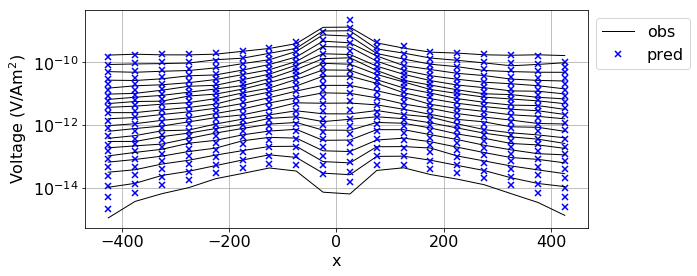

In [13]:
# fig = plt.figure(figsize=(5, 3))
fig = plt.figure(figsize=(9, 4))
for i in range(times.size):
    plt.plot(x, -DOBS[:, 0, i].flatten(), 'k-', lw=1, label='obs' if i == 0 else None)
    plt.plot(x, -pred[:,i].flatten(), 'bx', markeredgewidth=1.5, label='pred' if i == 0 else None)    
plt.yscale('log')   
plt.grid(which="both")
plt.legend(bbox_to_anchor=[1, 1])
plt.xlabel('x')
plt.ylabel('Voltage (V/Am$^2$)')
# plt.ylim(1e-15, 1e-9)

In [14]:
mesh1d = get_1d_cyl_mesh()
hx = np.ones(nSrc) * 50
mesh2D = Mesh.TensorMesh([hx, mesh1d.hz[mesh1d.vectorCCz<0.]], x0="CN")

In [15]:
def rect2D(p1, p2):    
    xy = np.c_[np.r_[p1[0], p2[0], p2[0], p1[0], p1[0]], np.r_[p1[1], p1[1], p2[1], p2[1], p1[1]]]
    return xy

p1 = np.r_[-50, -450]
p2 = np.r_[50, -50]
xy_box = rect2D(p1, p2)

/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1398: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  'yscale=%s' % (xscale, yscale))


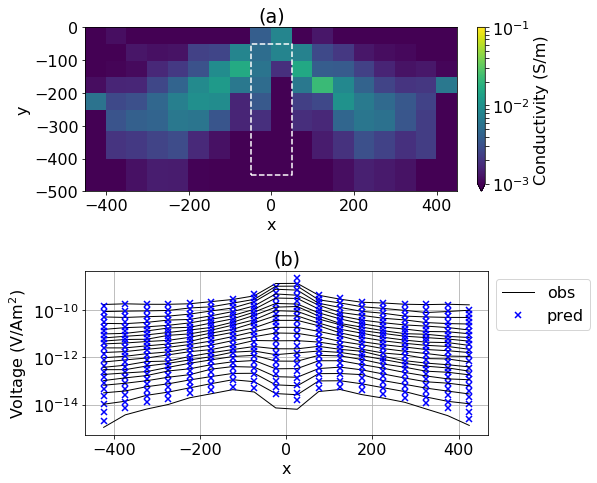

In [16]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(2, 1, figsize=(8, 3.5*2))

out = mesh2D.plotImage(sigma, pcolorOpts={'norm':LogNorm()}, clim=[1e-3, 1e-1], ax=ax[0])
cb = plt.colorbar(out[0], fraction=0.025, extend="min", ax=ax[0])
ax[0].set_ylim(-500, 0.)
plt.gca().set_aspect(1)
cb.set_label('Conductivity (S/m)')
ax[0].set_title("(a)")

ax[0].plot(xy_box[:,0], xy_box[:,1], 'w--')

for i in range(times.size):
    ax[1].plot(x, -DOBS[:, 0, i].flatten(), 'k-', lw=1, label='obs' if i == 0 else None)
    ax[1].plot(x, -pred[:,i].flatten(), 'bx', markeredgewidth=1.5, label='pred' if i == 0 else None)    
ax[1].set_yscale('log')   
ax[1].grid(which="both")
ax[1].legend(bbox_to_anchor=[1, 1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('Voltage (V/Am$^2$)')
ax[1].set_title("(b)")

plt.tight_layout()

In [17]:
np.save('dpred_1d_stitched', pred)
np.save('sigma_1d_stitched', sigma)
mesh2D.save(filename="mesh_1d_stitched.json")

'/Users/lindseyjh/git/simpeg-research/heagy_2018_AEM/notebooks/mesh_1d_stitched.json'